In [1]:
import itertools
from typing import *
from collections import deque

import pymorphy2
import nltk
import termcolor
from nltk.metrics import *
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import KeyedVectors

from sequence import Sequence, test

In [2]:
StrictPlainText = Sentence = List[str]
LazyPlainText = Iterator[str]
PlainText = Union[LazyPlainText, StrictPlainText]
LazyText = Iterator[Sentence]
StrictText = List[Sentence]
Text = Union[StrictText, LazyText]
CheckerResult = Any
CheckerWordResult = Tuple[CheckerResult, Tuple[str, str]]
SimilarityF = Callable[[str, str], CheckerResult]
Collocation = Tuple[str, str]

In [3]:
BUFFER_SIZE = 10
PUNCTUATION = set(',.!?:;-()[]{}\'"')
SIMILARITY_COLORS = ['white', 'magenta', 'blue', 'green', 'yellow', 'red', 'grey']

In [4]:
morph = pymorphy2.MorphAnalyzer()
example_text = open('pleos.txt', 'r').read()

In [5]:
word_vectors = KeyedVectors.load('ru-w2v/ru.bin')

In [61]:
def reverse(f):
    def wrap(*a, **kw):
        return 1 - f(*a, **kw)
    return wrap

In [6]:
def tokenize_text(raw_text: str) -> LazyText:
    return (nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(raw_text))

def plain_tokenize_text(raw_text: str) -> LazyPlainText:
    yield from itertools.chain.from_iterable(tokenize_text(raw_text))

In [7]:
def morph_text(text: Text) -> LazyText:
    return ([morph.parse(word)[0].normal_form for word in sent] for sent in text)

In [8]:
def is_punctuation(s: str) -> bool:
    return all((i in PUNCTUATION) for i in s)

def delete_punctuation(sentence: Sentence) -> Sentence:
    return list(itertools.filterfalse(is_punctuation, sentence))

def delete_punctuation_in_text(text: Text) -> LazyText:
    return map(delete_punctuation, text)

def join_text(text: Text) -> LazyPlainText:
    yield from itertools.chain.from_iterable(text)

In [9]:
def clear_text(text: Text) -> LazyPlainText:
    return join_text(delete_punctuation_in_text(morph_text(text)))

In [10]:
def check_word(calc_similarity: SimilarityF, max_buffer_size: int = 10) -> Generator[Iterator[CheckerWordResult], str, None]:
    buffer = deque(maxlen=max_buffer_size)
    while True:
        word = (yield)
        yield ((calc_similarity(word, i), (word, i)) for i in buffer)
        if word not in buffer:
            buffer.append(word)

def check_words(words: PlainText, *a, **kw) -> Iterator[CheckerWordResult]:
    word_checker = check_word(*a, **kw)
    word_checker.send(None)
    for word in words:
        yield from word_checker.send(word)
        next(word_checker)

In [11]:
def iter_window_collocations(words: PlainText, max_buffer_size: int = 10) -> Iterator[Collocation]:
    buffer = deque(maxlen=max_buffer_size)
    for word in words:
        yield ((word, i) for i in buffer)
        if word not in buffer:
            buffer.append(word)

def check_words_(words: PlainText, calc_similarity: SimilarityF, *a, **kw):
    for word_collocations in iter_window_collocations(words, *a, **kw):
        yield map(calc_similarity, word_collocatoins)

In [12]:
def word2vec_similarity(a, b):
    try:
        return word_vectors.wv.similarity(a, b)
    except KeyError:
        return 0

In [13]:
def local_alignement_similiarity(a, b):
    s = Sequence(a, b, match=1, dismatch=0, indel=0)
    s.make_lightweight_matrix()
    ls = len(a), len(b)
    #return s.max_score / ((len(a) + len(b)) / 2)
    return (max(ls) - s.max_score) / max(ls)

In [14]:
def edit_distance_similiarity(a, b):
    return edit_distance(a, b) / max(len(a), len(b))

In [15]:
def combine(*fs):
    def combined(*a):
        return sum(f(*a) for f in fs) / len(fs)
    return combined

In [64]:
def choose(xs, *els):
    res = []
    for el in els:
        res.append(xs[el])
    return res

In [72]:
class ColorText:
    def __init__(self, text: str):
        self.text = text
    
    def _float_to_color(self, n):
        n_of_colors = len(SIMILARITY_COLORS)
        for i, color in enumerate(SIMILARITY_COLORS[:-1]):
            if n <= ((1 + i) / n_of_colors):
                return color
        return SIMILARITY_COLORS[-1]
    
    def color_text(self, treshold, word_checker, in_place=False, with_pointers=True):
        colored_text = []
        word_checker.send(None)
        word_checker.send('')
        word_checker.send('')

        tautologies = []
        for word in plain_tokenize_text(self.text):
            if is_punctuation(word):
                colored_text.append(word)
                continue
            try:
                #checked = sorted(word_checker.send(morph.parse(word.lower())[0].normal_form))
                checked = sorted(word_checker.send(word.lower()))
                (bs, (_, bs_w)) = checked[-1]
                next(word_checker)
            except:
                continue
            color = self._float_to_color(bs)
            if bs >= treshold:
                tautologies.append(' '.join((word, bs_w, termcolor.colored('[' + str(bs) + ']', color))))
                if in_place:
                    word = ''.join((word, '(', bs_w, ')'))
                if with_pointers:
                    word = ''.join((word, '(', str(len(tautologies)), ')'))
            colored_word = termcolor.colored(word, color)
            colored_text.append(colored_word)
        res = ' '.join(colored_text)
        for p in PUNCTUATION:
            res = res.replace((' ' + p), p)
        res = res.replace('( ', ' (')
        print(res.replace('.', '\n'))
        print('\n'.join(') '.join((str(i), w)) for i, w in enumerate(tautologies)))
        #print('\n'.join(') '.join((str(i), w)) for i, w in enumerate(choose(tautologies, 1, 9, 11, 12, 13, 25, 26, 31))))
        #print('\n'.join(') '.join((str(i), w)) for i, w in enumerate(tautologies[1:4] + [tautologies[18]] + [tautologies[20]])))

In [74]:
t = ColorText(open('good/bulka.txt', 'r').read())

#t = ColorText("""""")
import time
s = time.time()
t.color_text(0.7, check_word(reverse(edit_distance_similiarity)))
st = time.time()
print(st - s)

У меня была мордашка
 Ее звали Булькой
 Она была(1) вся черная, только кончики передних лап были белые
 У всех мордашек нижняя челюсть длиннее верхней и верхние(2) зубы заходят за нижние, но у Бульки нижняя челюсть так выдавалась вперед, что палец можно было заложить между нижними и верхними зубами… Булька был(3) смирный и(4) не кусался, был(5) очень силен и(6) цепок
 Когда он, бывало, уцепится за что-нибудь, то стиснет зубы и повиснет, как тряпка, и(7) его, как(8) клеща, нельзя никак оторвать
 Один раз его(9) пускали на медведя, и он вцепился медведю(10) в ухо и(11) повис, как пиявка
 Медведь(12) бил его лапами, прижимал к себе, кидал из стороны в сторону(13), но не мог оторвать и повалился на голову, чтобы раздавить Бульку, но Булька(14) до тех пор на(15) нем держался, пока его не отлили холодной водой
 Рассказ Булька Я взял его(16) щенком и сам выкормил
 Когда я(17) ехал служить на Кавказ, я не хотел брать его и уехал(18) от него(19) потихоньку, а его(20) велел запереть
 На первой с

In [18]:
example = ColorText(
"""Я оглянулся посмотреть,
не оглянулась ли она,
чтоб посмотреть,
не оглянулся ли я"""
)
#                  порог 
example.color_text(0.5,  check_word(local_alignement_similiarity))

Я(1) оглянулся(2) посмотреть(3), не(4) оглянулась(5) ли(6) она(7), чтоб(8) посмотреть(9), не(10) оглянулся(11) ли(12) я(13)
0) Я  [1.0]
1) оглянулся  [1.0]
2) посмотреть я [1.0]
3) не я [1.0]
4) оглянулась  [1.0]
5) ли я [1.0]
6) она я [1.0]
7) чтоб я [1.0]
8) посмотреть я [1.0]
9) не я [1.0]
10) оглянулся  [1.0]
11) ли я [1.0]
12) я чтоб [1.0]


In [57]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def iterate_collocations(raw_text: str):
    yield from pairwise(clear_text(tokenize_text(raw_text)))

In [58]:
def compare(comp: Iterator[Tuple[Collocation, bool]], similarity_f: SimilarityF, threshold: int = 0.5) -> Tuple[int, int, int, int]:
    """Compare results of similarity of collocations with expected and return tuple (fn, fp, tn, tp)."""
    stats = [[0, 0], [0, 0]]
    similarity_f = reverse(similarity_f)
    for (collocation, expected) in comp:
        res = similarity_f(*collocation) >= threshold
        stats[int(res is expected)][int(res)] += 1
    return tuple(itertools.chain.from_iterable(stats))

In [75]:
def iter_without_punctuation(raw_text):
    for word in plain_tokenize_text(raw_text):
        if not is_punctuation(word):
            yield word

def plain_iter_without_punctuation(i):
    yield from itertools.chain.from_iterable(iter_window_collocations(iter_without_punctuation(i)))

compare(zip(plain_iter_without_punctuation(open('good/bulka.txt', 'r').read()), itertools.repeat(False)),
        local_alignement_similiarity)

(0, 92, 2631, 0)

In [76]:
import matplotlib.pyplot as plt
import numpy as np

In [77]:
def roc(comp, *a, step=0.01, **kw):
    x = []
    y = []

    threshold = 0
    while threshold <= 1:
        fn, fp, tn, tp = compare(
            comp,
            *a, **kw,
            threshold=threshold
        )
        threshold += step
        print(fn, fp, tn, tp)
        try:
            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)
            print('', tpr)
            print('', fpr)
        except ZeroDivisionError:
            continue
        x.append(fpr)
        y.append(tpr)
    return x, y

In [78]:
def mix(*ts):
    r = []
    for (t, what) in ts:
        r.append(zip(plain_iter_without_punctuation(t), itertools.repeat(what)))
    return list(itertools.chain.from_iterable(r))

In [79]:
comp = mix(
    (open('good/bulka.txt', 'r').read(), False),
    (open('pleos.txt', 'r').read(), True),
)

In [80]:
fpr, tpr = roc(comp, local_alignement_similiarity)

0 2723 0 1522
 1.0
 1.0
112 1484 1239 1410
 0.926412614980289
 0.5449871465295629
112 1484 1239 1410
 0.926412614980289
 0.5449871465295629
112 1484 1239 1410
 0.926412614980289
 0.5449871465295629
112 1484 1239 1410
 0.926412614980289
 0.5449871465295629
112 1484 1239 1410
 0.926412614980289
 0.5449871465295629
112 1484 1239 1410
 0.926412614980289
 0.5449871465295629
120 1484 1239 1402
 0.9211563731931669
 0.5449871465295629
142 1473 1250 1380
 0.9067017082785808
 0.5409474843922145
170 1473 1250 1352
 0.8883048620236531
 0.5409474843922145
263 1435 1288 1259
 0.8272010512483574
 0.5269922879177378
263 1435 1288 1259
 0.8272010512483574
 0.5269922879177378
337 1372 1351 1185
 0.778580814717477
 0.5038560411311054
411 1154 1569 1111
 0.7299605781865965
 0.4237972824091076
439 1154 1569 1083
 0.7115637319316689
 0.4237972824091076
509 960 1763 1013
 0.6655716162943496
 0.35255233198677927
543 958 1765 979
 0.6432325886990802
 0.3518178479618068
647 735 1988 875
 0.5749014454664915
 0.2

In [81]:
fpr_l, tpr_l = roc(comp, edit_distance_similiarity)

0 2723 0 1522
 1.0
 1.0
303 1186 1537 1219
 0.8009198423127464
 0.4355490268086669
303 1186 1537 1219
 0.8009198423127464
 0.4355490268086669
303 1186 1537 1219
 0.8009198423127464
 0.4355490268086669
303 1186 1537 1219
 0.8009198423127464
 0.4355490268086669
303 1186 1537 1219
 0.8009198423127464
 0.4355490268086669
303 1186 1537 1219
 0.8009198423127464
 0.4355490268086669
322 1186 1537 1200
 0.7884362680683311
 0.4355490268086669
371 1175 1548 1151
 0.7562417871222076
 0.4315093646713184
439 1175 1548 1083
 0.7115637319316689
 0.4315093646713184
583 1140 1583 939
 0.6169513797634691
 0.4186558942343004
583 1140 1583 939
 0.6169513797634691
 0.4186558942343004
679 1079 1644 843
 0.5538764783180026
 0.3962541314726405
777 862 1861 745
 0.4894875164257556
 0.3165626147631289
818 862 1861 704
 0.46254927726675427
 0.3165626147631289
900 699 2024 622
 0.40867279894875164
 0.25670216672787366
938 696 2027 584
 0.38370565045992117
 0.255600440690415
1019 507 2216 503
 0.3304862023653088
 0

In [86]:
fpr_w, tpr_w = roc(comp, reverse(word2vec_similarity))

377 2517 0 1351
 0.7818287037037037
 1.0
1763 1058 1424 0
 0.0
 0.4262691377921031
1819 1002 1424 0
 0.0
 0.41302555647155814
1866 955 1424 0
 0.0
 0.4014291719209752
1920 901 1424 0
 0.0
 0.3875268817204301
2001 820 1424 0
 0.0
 0.36541889483065954
2046 775 1424 0
 0.0
 0.35243292405638926
2090 731 1424 0
 0.0
 0.3392111368909513
2137 684 1424 0
 0.0
 0.32447817836812143
2190 631 1424 0
 0.0
 0.3070559610705596
2222 599 1424 0
 0.0
 0.29609490855165593
2278 543 1424 0
 0.0
 0.27605490594814436
2330 491 1424 0
 0.0
 0.2563968668407311
2379 442 1424 0
 0.0
 0.23687031082529475
2416 405 1424 0
 0.0
 0.2214324767632586
2445 376 1424 0
 0.0
 0.2088888888888889
2476 345 1424 0
 0.0
 0.1950254381006218
2499 322 1424 0
 0.0
 0.18442153493699887
2522 299 1424 0
 0.0
 0.1735345327916425
2543 278 1424 0
 0.0
 0.16333725029377202
2555 266 1424 0
 0.0
 0.15739644970414202
2574 247 1424 0
 0.0
 0.1478156792339916
2586 235 1424 0
 0.0
 0.1416515973477999
2595 226 1424 0
 0.0
 0.13696969696969696
260

In [84]:
def plot_roc(*fpr_tprs):
    for (fpr, tpr), c in zip(fpr_tprs, 'bgyrm'):
        plt.plot(fpr, tpr, c, label = 'AUC = %0.2f' % np.trapz(tpr, fpr))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

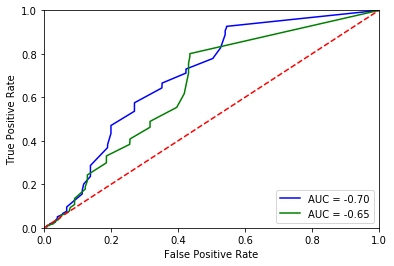

In [88]:
plot_roc((fpr, tpr), (fpr_l, tpr_l))

In [ ]:
# This is the ROC curve
plt.plot(*roc(open('good/bulka.txt', 'r').read(), lambda *a: 1 - local_alignement_similiarity(*a), itertools.repeat(True), step=0.5))
plt.show() 

In [ ]:
# This is the AUC
auc = np.trapz(y,x)